In [1]:
#Import libraries 
import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [2]:
#Batch Size to process 32 images 
batch_size = 32
#PyTorch Image Augumentation Technique 
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
#Load the data for training network
train_ds = DataLoader(datasets.CIFAR10("data", train=True, transform=transform, download=True), batch_size=batch_size)
valid_ds = DataLoader(datasets.CIFAR10("data", train=False, transform=transform, download=True), batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#Neural Network architecture 
class CNNModel(nn.Module):
    
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024 * 6 * 6, 2048), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Linear(512, num_classes),
            
            
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#T
network = CNNModel(num_classes=10)
network.cuda()

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pa

In [4]:
#load the model to run through cuda 
model = CNNModel(num_classes=10)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pa

In [5]:
#Create the function to plot the values of accuaracy and loss of the network 
def display_message_and_metrics(message, metrics, accuaracy_list):
    display.clear_output(wait=False) 
    if len(metrics["loss"]) > 0:
        pd.DataFrame(metrics).plot()
        plt.show()
    if accuracy_list:
        plt.plot(accuracy_list)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.show()
    print(message)

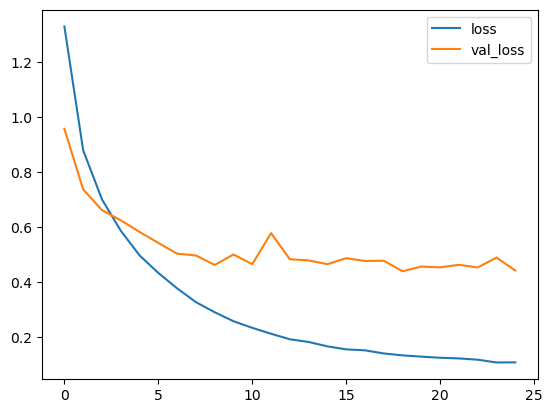

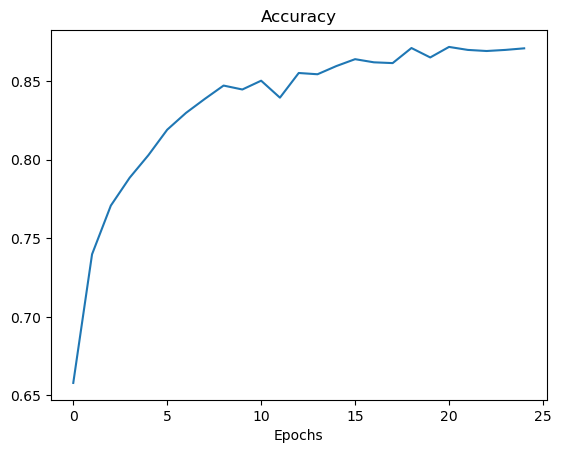

Training Loss: 0.11 Validation Loss: 0.44 accuracy: 0.87


In [6]:
epochs = 25
#Calculate the total size of training data
train_steps = len(train_ds)
#Calculate the total size of validation data
valid_steps = len(valid_ds)
#Optimizer for the generalisation of neural network 
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)
#Calculate the losses of the network
loss_fn = torch.nn.CrossEntropyLoss()
#Create the array to plot the graph for accuracy and loss
metrics = {"loss": [], "val_loss": []}
accuracy_list = []

for epoch in range(epochs):    
    train_losses = []
    valid_losses = []
    model.train()
    begin = time.time()
    #Training Loop for batch
    for batch in train_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.data.item())
        #Comparing the value of training losses
        if len(train_losses) > 0 and len(train_losses) % 50 == 0:
            current = time.time()
            elapsed = current - begin
            display_message_and_metrics(
                "Epoch %d: [Training] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(train_losses)) * train_steps), 
                metrics, accuracy_list
            )
    model.eval()
    num_correct = 0
    num_samples = 0
    begin = time.time()
    #Validation loop for batch
    for batch in valid_ds:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        valid_losses.append(loss.data.item())
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_samples += correct.shape[0]
        #Comparing the value of validation losses
        if len(valid_losses) > 0 and len(valid_losses) % 50 == 0:
            current = time.time()
            elapsed = current - begin
            display_message_and_metrics(
                "Epoch %d: [Validation] %.2fs/%.2fs"%(epoch + 1, elapsed, elapsed / float(len(valid_losses)) * valid_steps), 
                metrics, accuracy_list
            )
    #To calculate the mean of the train_losses tensor       
    train_loss = torch.mean(torch.Tensor(train_losses)).item()
    #To calculate the mean of the valid_losses tensor       
    valid_loss = torch.mean(torch.Tensor(valid_losses)).item()
    #Accuracy calculations
    accuracy = num_correct / num_samples if num_samples > 0 else 0
    metrics["loss"].append(train_loss)
    metrics["val_loss"].append(valid_loss)
    accuracy_list.append(accuracy)
    display.clear_output(wait=False) 
    pd.DataFrame(metrics).plot()
    plt.xlabel("Epochs")
    plt.show()
    plt.plot(accuracy_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.show()
    display_message_and_metrics(
        "Training Loss: %.2f Validation Loss: %.2f accuracy: %.2f" %(train_loss, valid_loss, accuracy), 
        metrics, accuracy_list
    )

In [7]:
#Saving the model trained
PATH = './cifarfinal.pth'
torch.save(network.state_dict(), PATH)

network = CNNModel(num_classes=10)
network.load_state_dict(torch.load(PATH))

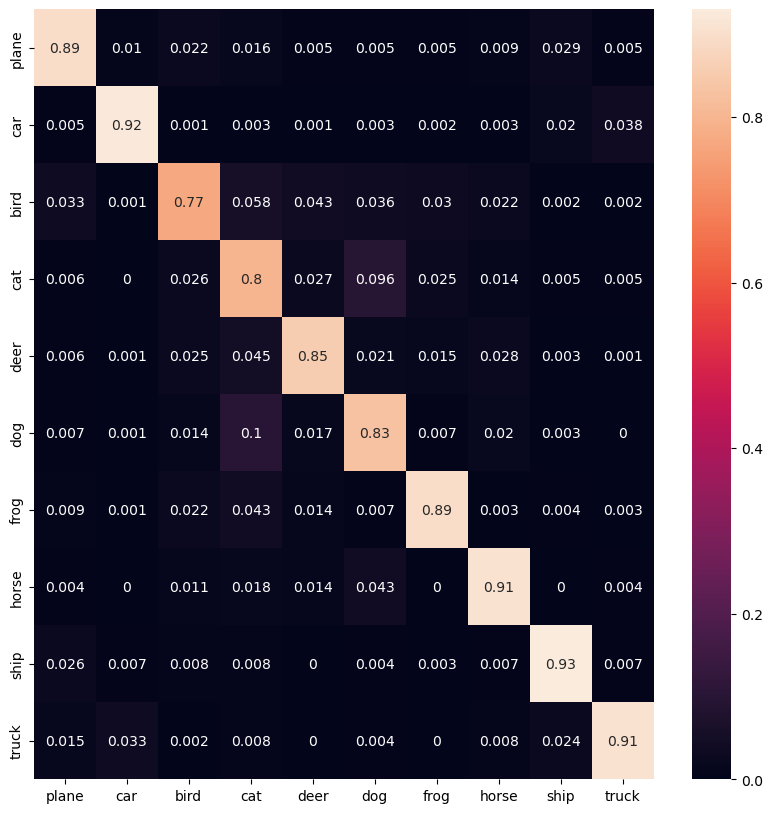

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# set model to eval mode and move to GPU if available
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# iterate over test data
for inputs, labels in valid_ds:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
